In [1]:
import os
import gdown
import zipfile
import numpy as np
import tensorflow as tf

from fxpmath import Fxp
from tensorflow.keras.optimizers import Adam

from callbacks import all_callbacks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from qkeras import QDense, QActivation
from qkeras.quantizers import binary, ternary, quantized_relu, quantized_bits

seed = 0
width = 64
num_layers = 2
reuse_factor = 1
epochs = 5

np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
saved_model_dir = f'exp_8bit_qnn'
# delete the saved_model_dir if it exists
if os.path.exists(saved_model_dir):
    import shutil
    shutil.rmtree(saved_model_dir)
# create the saved_model_dir if it doesn't exist
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)


2025-02-20 08:53:31.592612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 08:53:31.619250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 08:53:31.619274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 08:53:31.619297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 08:53:31.624299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 08:53:31.624629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# download data
# Extracted file ID from the shared link
file_id = "1DaabPwQX582CAt54OTUvWpAnZml3b23A"

# Google Drive direct download link format
url = f"https://drive.google.com/uc?id={file_id}"

# Specify the output file name
output = "data.zip"

# Download the file
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall("unzipped_data")

print(f"Downloaded: {output}")

Downloaded: data.zip


In [3]:
# Define the fixed-point configuration
# For example, ap_fixed<16,8> corresponds to 16 total bits with 8 integer bits
total_bits = 16
integer_bits = 6
fractional_bits = total_bits - integer_bits

X_train_val = np.load('unzipped_data/X_train_val.npy').astype(np.float32)
X_test = np.load('unzipped_data/X_test.npy').astype(np.float32)

# convert input data to Fxp
X_train_val_fxp = Fxp(X_train_val, signed=True, n_word=total_bits, n_frac=fractional_bits).astype(np.float32)
X_test_fxp = Fxp(X_test, signed=True, n_word=total_bits, n_frac=fractional_bits).astype(np.float32)

# save the converted data
np.save('unzipped_data/X_train_val_fxp.npy', X_train_val_fxp)
np.save('unzipped_data/X_test_fxp.npy', X_test_fxp)

y_train_val = np.load('unzipped_data/y_train_val.npy')
y_test = np.load('unzipped_data/y_test.npy')
classes = np.load('unzipped_data/classes.npy', allow_pickle=True)
print(X_train_val_fxp[:5])
print(X_test.shape)

[[-0.5107422   0.47070312  0.38476562  0.06933594 -0.04101562 -0.14160156
  -0.86816406 -0.5527344  -0.86816406 -0.7832031  -0.80859375 -0.84765625
  -0.96484375 -0.83496094  0.18652344  0.46484375]
 [ 0.7480469  -0.49804688  0.12304688  0.03613281  0.56152344  0.06640625
   0.7236328  -0.09960938  0.7236328  -0.51464844 -0.65722656 -0.5019531
  -0.19628906 -0.4345703   0.2626953  -0.8720703 ]
 [ 0.8544922  -0.90625    -1.2177734  -0.8486328  -1.1044922  -0.6230469
  -0.02929688  0.19628906 -0.02929688  0.9121094   1.1347656   1.7070312
   0.9628906   1.3779297  -1.2890625  -0.73339844]
 [ 1.2910156  -1.0869141  -1.203125   -0.84765625 -1.1044922  -0.6230469
  -0.47851562 -0.29492188 -0.47851562  0.31933594  0.90625     1.6035156
   0.42285156  0.796875   -1.2773438  -1.1484375 ]
 [-0.31933594  0.578125   -0.08984375 -0.04394531  0.71972656  0.7324219
   1.7363281   1.5029297   1.7363281  -0.703125   -1.0673828  -1.015625
  -0.38476562 -0.47558594  0.27441406 -0.27148438]]
(166000, 16)

# Construct Model
* Two layers of MLP, width = 64
* 8-bit quantization on weight and activation

In [5]:
kernel_quantizer = ternary(alpha=0.125)
accum_quantizer = quantized_bits(bits=16, integer=6)
act_quantizer = ternary(alpha=1)

model = Sequential()
model.add(
   QDense(width, input_shape=(16,), name = f'fc0',
               kernel_quantizer = kernel_quantizer,
               # activation = accum_quantizer,
               use_bias = False)
        )
model.add(
    BatchNormalization(name = f'bn0')
)
model.add(
    QActivation(act_quantizer, name = f'act0')
)
model.add(
   QDense(width, name = 'fc1',
               kernel_quantizer = kernel_quantizer,
               # activation = accum_quantizer,
               use_bias = False)
)
model.add(
    BatchNormalization(name = f'bn1')
)
model.add(
    QActivation(act_quantizer, name = f'act1')
)
model.add(
   QDense(5, name = 'output',
               kernel_quantizer = kernel_quantizer,
               activation = act_quantizer) 
)

model.summary()

adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['hinge'], metrics=['accuracy'])
callbacks = all_callbacks(
    stop_patience=1000,
    lr_factor=0.5,
    lr_patience=10,
    lr_epsilon=0.000001,
    lr_cooldown=2,
    lr_minimum=0.0000001,
    outputDir=f'{saved_model_dir}/model_3',
)
if os.path.exists(f'{saved_model_dir}/KERAS_check_best_model.h5'):
    model.load_weights(f'{saved_model_dir}/KERAS_check_best_model.h5')
else:
    model.fit(
        X_train_val_fxp,
        y_train_val,
        batch_size=1024,
        epochs=epochs,
        validation_split=0.25,
    shuffle=True,
    callbacks=callbacks.callbacks,
)
# Save the model again but with the pruning 'stripped' to use the regular layer types
model.save(f'{saved_model_dir}/KERAS_check_best_model.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (QDense)                (None, 64)                1024      
                                                                 
 bn0 (BatchNormalization)    (None, 64)                256       
                                                                 
 act0 (QActivation)          (None, 64)                0         
                                                                 
 fc1 (QDense)                (None, 64)                4096      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                                 
 act1 (QActivation)          (None, 64)                0         
                                                                 
 output (QDense)             (None, 5)                

Epoch 1/5


/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.ternary'>, which may lead to improper serialization.
  warnings.warn(


  1/487 [..............................] - ETA: 5:24 - loss: 0.9719 - accuracy: 0.1768
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 10/487 [..............................] - ETA: 3s - loss: 0.9732 - accuracy: 0.1993  
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 20/487 [>.............................] - ETA: 2s - loss: 0.9719 - accuracy: 0.2033
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 31/487 [>.............................] - ETA: 2s - loss: 0.9677 - accuracy: 0.2061
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 42/487 [=>............................] - ETA: 2s - loss: 0.9659 - accuracy: 0.2064
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 53/487 [==>...........................] - ETA: 2s - loss: 0.9651 - accuracy: 0.2067
Epoch 1: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch01.keras
 63/487 [==>......

/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 23/487 [>.............................] - ETA: 2s - loss: 0.7838 - accuracy: 0.3828
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 34/487 [=>............................] - ETA: 2s - loss: 0.7845 - accuracy: 0.3849
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 45/487 [=>............................] - ETA: 2s - loss: 0.7847 - accuracy: 0.3856
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 56/487 [==>...........................] - ETA: 2s - loss: 0.7840 - accuracy: 0.3866
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 67/487 [===>..........................] - ETA: 2s - loss: 0.7831 - accuracy: 0.3863
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 77/487 [===>..........................] - ETA: 2s - loss: 0.7813 - accuracy: 0.3874
Epoch 2: saving model to exp_8bit_qnn/model_3/KERAS_check_model_epoch02.keras
 87/487 [====>........

In [6]:
import hls4ml
import plotting
from math import log2, floor

config = hls4ml.utils.config_from_keras_model(model, granularity='name', 
                                              default_precision='ap_fixed<16,6>')

config['Model']['ReuseFactor'] = reuse_factor
config['Model']['InputData'] = "unzipped_data/X_test_fxp.npy"
config['Model']['OutputPredictions'] = "unzipped_data/y_test.npy"

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
    config['LayerName'][layer]['ReuseFactor'] = reuse_factor


# config['LayerName']['fc0_input']['Precision'] = 'ap_fixed<16,6>'

config['LayerName'][f'fc0']['Precision']['accum'] = 'ap_fixed<16,6>'
config['LayerName'][f'fc0']['Precision']['result'] = 'ap_fixed<16,6>'
# config['LayerName'][f'fc0_linear']['Precision'] = 'ap_fixed<16,6>'
# config['LayerName'][f'batch_normalization']['Precision'] = 'ap_fixed<32,12>'

for layer_idx in range(2, num_layers):    
    config['LayerName'][f'fc{layer_idx}']['Precision']['accum'] = f'ap_int<{floor(log2(width))+1}>'
    config['LayerName'][f'fc{layer_idx}']['Precision']['result'] = 'ap_fixed<16,6>'
    config['LayerName'][f'fc{layer_idx}_linear']['Precision'] = 'ap_fixed<16,6>'
    config['LayerName'][f'batch_normalization_{layer_idx}']['Precision'] = 'ap_fixed<16,6>'
    
config['LayerName']['output']['Precision']['accum'] = f'ap_int<{floor(log2(width))+1}>'
config['LayerName']['output']['Precision']['result'] = 'ap_fixed<16,6>'

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=f'{saved_model_dir}/hls4ml_prj', part='xcu50-fsvh2104-2-e', backend='Vitis',
    input_data_tb="unzipped_data/X_test_fxp.npy", 
    output_data_tb="unzipped_data/y_test.npy"
)
hls_model.compile()

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/hls4ml/converters/__init__.py:28: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)
/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.ternary'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Sequential
Topology:
Layer name: fc0_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc0, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: bn0, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: act0, layer type: TernaryTanh, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: bn1, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: act1, layer type: TernaryTanh, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 5]
-----------------------------------
Model
  Precision
    default:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       Fal

In [7]:
X = X_test_fxp
# X = np.round(X * 2**10) * 2**-10
y_qkeras = model.predict(np.ascontiguousarray(X))
y_hls = hls_model.predict(np.ascontiguousarray(X))

print(y_qkeras - y_hls)
print(np.sum(y_qkeras - y_hls))

np.save(f'{saved_model_dir}/y_qkeras.npy', y_qkeras)
np.save(f'{saved_model_dir}/y_hls.npy', y_hls)

from sklearn.metrics import accuracy_score
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

 138/5188 [..............................] - ETA: 3s

5188/5188 [==============================] - 3s 644us/step
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
0.0
Accuracy pruned, quantized: 0.5142168674698795
Accuracy hls4ml: 0.5142168674698795


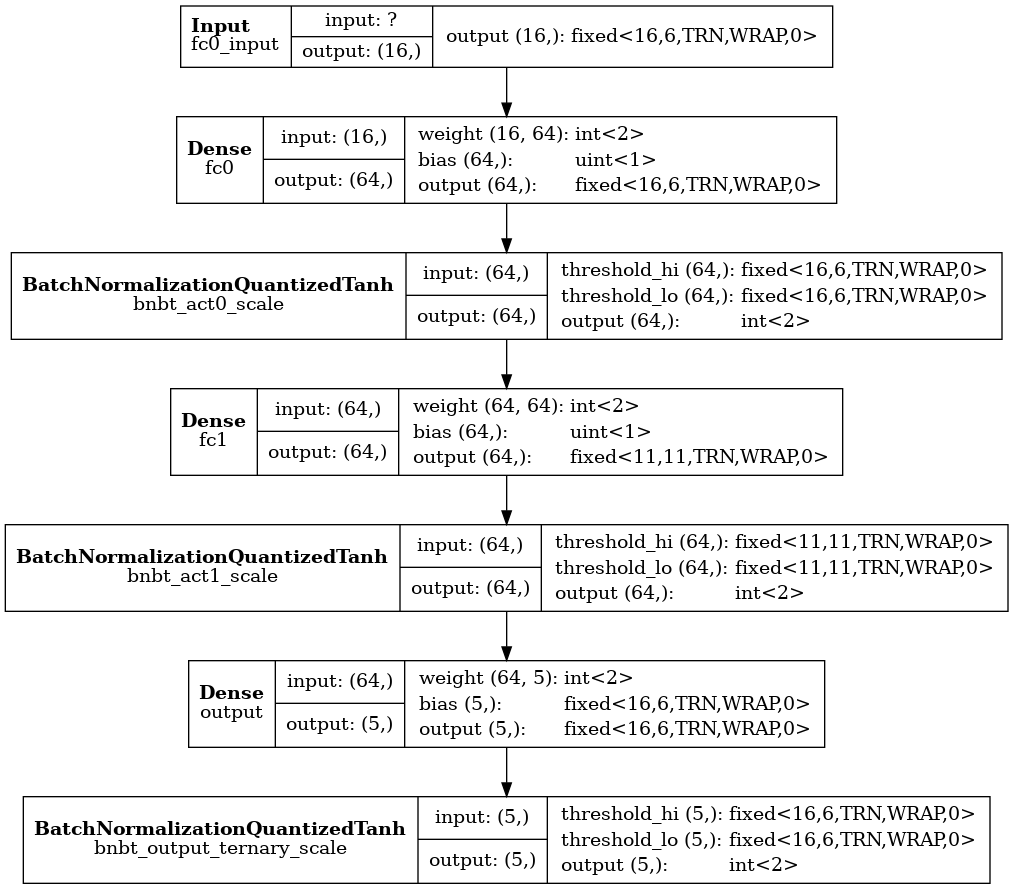

In [8]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

# Visualization

In [9]:
hls_model.config.trace_output = True
hls_model.write()

# used for tracing individual outputs from each layer
# trace_outputs is a dict, keys are layer names, values are numpy arrays of layer outputs
# hls_model._compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X))
print(hls4ml_trace.keys())

keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, np.ascontiguousarray(X))
print(keras_trace.keys())

Writing HLS project


/home/jiaming/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.ternary'>, which may lead to improper serialization.
  warnings.warn(


Done
Recompiling myproject with tracing
Writing HLS project
Done
dict_keys(['fc0', 'bnbt_act0_scale', 'fc1', 'bnbt_act1_scale', 'output', 'bnbt_output_ternary_scale'])
5188/5188 [==============================] - 4s 809us/step
Done taking outputs for Keras model.
dict_keys(['output', 'fc0', 'bn0', 'act0', 'fc1', 'bn1', 'act1', 'output_ternary'])


In [ ]:
from hls4ml.model.profiling import numerical
import matplotlib.pyplot as plt

plots = numerical(model = model, hls_model = hls_model, X = X)
plt.show()
